In [1]:
import numpy as np
from matplotlib import pyplot as plt

# load data
train_data = np.loadtxt("hwk3data/EMGaussian.train")
test_data = np.loadtxt("hwk3data/EMGaussian.test")

for random seed 10: algo converged after 8 iterations, loss= 6.4812


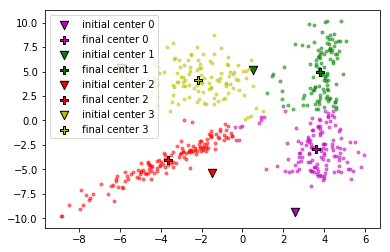

for random seed 20: algo converged after 18 iterations, loss= 12.7582


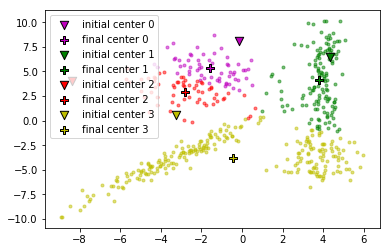

for random seed 30: algo converged after 9 iterations, loss= 6.4812


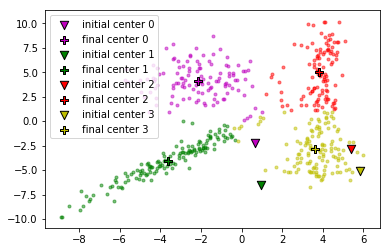

for random seed 40: algo converged after 24 iterations, loss= 6.4803


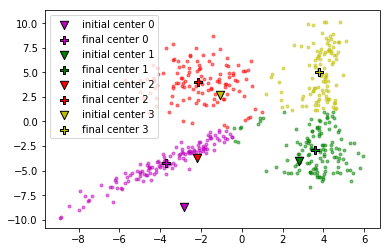

In [2]:
# Q.8. (a)

# K-means algorithm
def cost_j(data, z, mu):
    j = 0
    for i in range(data.shape[0]):
        j += (np.linalg.norm(data[i] - mu[z[i]]))**2
    return j/data.shape[0]

def kmeans(data, k, mus=[]):
    n = data.shape[0]
    d = data.shape[1]
    
    if np.array_equal(mus, []):
        mus=np.random.rand(k, d)
    
    zs = np.zeros(n, dtype=int)
    for iter_count in range(10000):
        zs_new = np.array([np.argmin(np.linalg.norm(mus - data_i, axis=1))\
         for data_i in data])
        
        if np.array_equal(zs_new, zs):
            # print("K-means converging after {} iterations".format(iter_count))
            return zs, mus, cost_j(data, zs, mus), iter_count+1
            break
        zs = zs_new
        
        cluster_sums = np.zeros((k, d))
        cluster_counts = np.zeros((k, 1))
        for i in range(n):
            cluster_sums[zs[i]] += data[i]
            cluster_counts[zs[i]] += 1
        mus = cluster_sums/cluster_counts

# --------------------------------------------------------------------------------

k = 4
for seed in [10, 20, 30, 40]:
    np.random.seed(seed)
    d = train_data.shape[1]
    top = np.max(train_data, axis=0)
    bottom = np.min(train_data, axis=0)
    
    mu_ini = np.random.random([k, d])
    mu_ini *= (top - bottom)
    mu_ini += bottom
    
    zs, mus, cost, iters = kmeans(train_data, k, mu_ini)
    print("for random seed {0}: algo converged after {1} iterations, loss= {2:.4f}"\
        .format(seed, iters, cost))
    
    colors = ['m', 'g', 'r', 'y']
    for i in range(k):
        zs_i = zs == i
        x, y = [train_data[zs_i, 0], train_data[zs_i, 1]]
        plt.scatter(x, y, marker='.', c=colors[i], alpha=0.5)
        plt.scatter(mu_ini[i][0], mu_ini[i][1], marker='v', c=colors[i], s=70,\
         edgecolors='k', label="initial center {}".format(i))
        plt.scatter(mus[i][0], mus[i][1], marker='P', c=colors[i], s=70,\
         edgecolors='k', label="final center {}".format(i))
    plt.legend()
    plt.show()


### 8.(a)
The objective-cost (loss) reported above is mean of squared-distance from the center of the assigned clusters for all the points. \\
Comparison over different initializations - \\
* As we can see above that initialing with different centers result in different final cluster centers. \\
* Also the number of iterations needed for converging also depends on the initialization of the centers. \\
* As we can see here - the clustering for the second case(seed = 20) is significantly worse than the other three clusterings. The mean objective cost in 2nd case is 12.758 where as in the other three cases, it is around 6.48. So the local minima for 2nd case is significantly worse than the global minima.

In [3]:
# ====================================================================
# Code for 8.(b) and 8.(c) together

class GMM:
    def __init__(self, k, is_isotropic=True):
        self.k = k
        self.is_isotropic=is_isotropic

    def e_step(self, data):
        n, d = data.shape
        data_c = np.array([data - mu for mu in self.mus])

        if self.is_isotropic:
            diff = np.linalg.norm(data_c, axis=2).T ** 2
            taus = 1 / (np.sqrt(2 * np.pi * self.sigmas) ** d) \
            * np.exp(-1 / 2 * diff / self.sigmas) * self.pis

        else:
            xsiginvx = np.array([np.sum(xc_i.dot(np.linalg.inv(sigma_i)) \
                * xc_i, axis=1) for sigma_i, xc_i in zip(self.sigmas, data_c)]).T
            taus = 1 / np.sqrt(np.array([np.linalg.det(2 * np.pi * sigma_i) for \
                sigma_i in self.sigmas])) * np.exp(-1 / 2 * xsiginvx) * self.pis

        self.taus = taus / taus.sum(axis=1, keepdims=True)
        return taus / self.pis

    def m_step(self, data):
        n, d = data.shape
        self.pis = self.taus.mean(axis=0)
        self.mus = np.array([np.expand_dims(tau, axis=1) * data for tau in \
            self.taus.T]).sum(axis=1) / self.taus.T.sum(axis=1, keepdims=True)

        data_c = np.array([data - mu for mu in self.mus])

        if self.is_isotropic:
            diff = np.linalg.norm(data_c, axis=2).T ** 2
            self.sigmas = (self.taus * diff).sum(axis=0) / d / self.taus.sum(axis=0)

        else:
            s = np.array([ [np.expand_dims(xc_ij, axis=1) @ np.expand_dims(\
                xc_ij, axis=1).T for xc_ij in xc_i] for xc_i in data_c])
            self.sigmas = (self.taus.T.reshape(self.k, n, 1, 1) * s).sum(axis=1)\
             / self.taus.sum(axis=0).reshape(self.k, 1, 1)


    def train(self, data, seed=None):
        np.random.seed(seed)
        n, d = data.shape
        top = np.max(data, axis=0)
        bottom = np.min(data, axis=0)
        mu_ini = np.random.random([k, d])
        mu_ini *= (top - bottom)
        mu_ini += bottom

        kmeans_zs, kmeans_mus, cost, iters = kmeans(data, k, mu_ini)

        self.mus = kmeans_mus
        zs = kmeans_zs
        self.pis = np.array([(zs == k).sum() / n for k in range(self.k)])

        if self.is_isotropic:
            self.sigmas =  36*np.ones(self.k)
        else:
            self.sigmas = np.array([36*np.identity(d) for _ in range(self.k)])

        for i in range(10000):
            mus, sigmas, pis = self.mus.copy(), self.sigmas.copy(), self.pis.copy()
            self.e_step(data)
            self.m_step(data)

            change = max( np.linalg.norm(pis - self.pis),\
                np.linalg.norm(mus - self.mus), np.linalg.norm(sigmas - self.sigmas))
            if change < 0.00001:
                print("for random seed: {} - algo converged after {} iterations"\
                      .format(seed, i+1))
                break

    def log_lh(self, data):
        taus = self.e_step(data) * self.pis
        return np.mean((self.taus * np.log(taus)).sum(axis=1))

    def plot(self, data, seed=None, show=True):
        llik = self.log_lh(data)
        zs = np.argmax(self.taus, axis=1)

        top = data.max(axis=0)
        bottom = data.min(axis=0)
        grid_x = np.linspace(bottom[0], top[0], 100)
        grid_y = np.linspace(bottom[1], top[1], 100)

        mesh_x, mesh_y = np.meshgrid(grid_x, grid_y)
        mesh_taus = self.e_step(np.array([[ii, jj] for ii in grid_x for jj in grid_y]))

        colors = ['m', 'g', 'r', 'y']
        for i in range(self.k):
            z_i = zs == i
            plt.scatter(data[z_i, 0], data[z_i, 1], marker='.',\
             c=colors[i], alpha=0.5)
            plt.scatter(self.mus[i][0], self.mus[i][1],  marker='P', \
                c=colors[i], s=70, edgecolors='k', label="mu {}".format(i))

            mesh_z = mesh_taus[:, i]
            plt.contour(mesh_x, mesh_y, mesh_z.reshape(100, 100).T, levels=[.01], colors=colors[i])

        plt.legend()
        title = ('Isotropic ' if self.is_isotropic else 'General ') + 'GMM'
        seed_txt = ', random seed= ' + str(seed) if seed else ''
        plt.title(title + seed_txt + ': log-likelihood= {0:0.6f}'.format(llik))
        plt.show()


for random seed: 10 - algo converged after 132 iterations


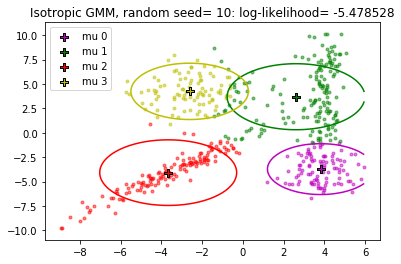

for random seed: 20 - algo converged after 136 iterations


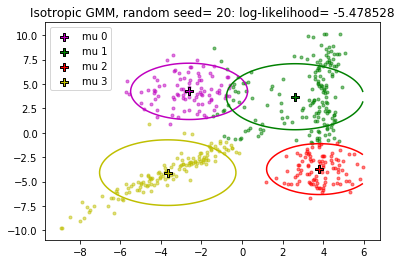

for random seed: 30 - algo converged after 132 iterations


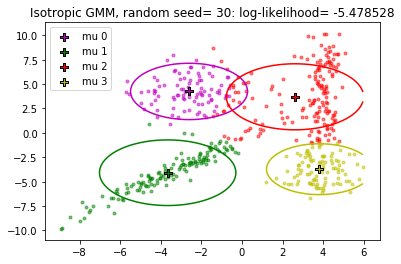

for random seed: 40 - algo converged after 136 iterations


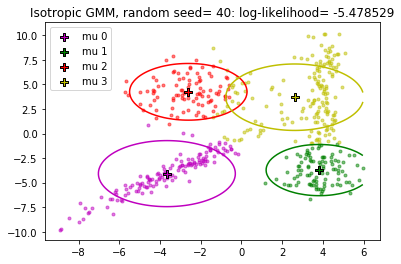

for random seed: 10 - algo converged after 84 iterations


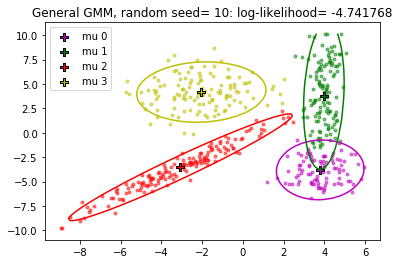

for random seed: 20 - algo converged after 110 iterations


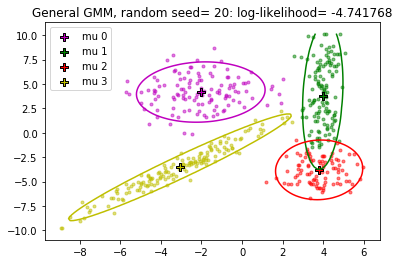

for random seed: 30 - algo converged after 84 iterations


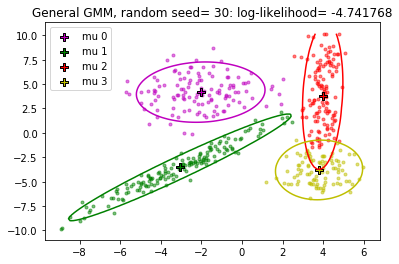

for random seed: 40 - algo converged after 84 iterations


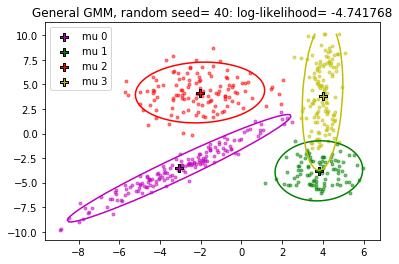

In [4]:
# plots for 8.(b)
gmm_iso = GMM(k=4, is_isotropic=True)
for seed in [10, 20, 30, 40]:
    gmm_iso.train(train_data, seed=seed)
    gmm_iso.plot(train_data, seed=seed)
    
# plots for 8.(c)
gmm_gen = GMM(k=4, is_isotropic=False)
for seed in [10, 20, 30, 40]:
    gmm_gen.train(train_data, seed=seed)
    gmm_gen.plot(train_data, seed=seed)

In [5]:
print("For GMM with Isotropic covariance:")
train_llik, test_llik = [gmm_iso.log_lh(train_data), gmm_iso.log_lh(test_data)]
print("normalized log-likelihoods: on training data = {0:.6f}, on test data = {1:.6f}"\
     .format(train_llik, test_llik))

print("For GMM with general covariance:")
train_llik, test_llik = [gmm_gen.log_lh(train_data), gmm_gen.log_lh(test_data)]
print("normalized log-likelihoods: on training data = {0:.6f}, on test data = {1:.6f}"\
     .format(train_llik, test_llik))

For GMM with Isotropic covariance:
normalized log-likelihoods: on training data = -5.478529, on test data = -5.437759
For GMM with general covariance:
normalized log-likelihoods: on training data = -4.741768, on test data = -4.907126


### 8.(d)
Comments: \\
* As we can see above (both visually and through log-likelihood values) that the GMM with general covariance is giving best results on both the training data and the test data. \\
* For GMM with isotropic gaussian, we see above (through log-likelihood values) that the model perfoms slightly better on test data than on training data. Since the underlying data is not isotropic thus it may simply be the case that test data has less of such points which are becoming outliers for the learnt isotropic gaussian. \\
* We had seen in 8.(a) that k-means was giving a significantly worse clustering for a particular initialization (seed=20). \\
    - We can see above that both the GMMs are not affected (in terms of final clustering) when initialized with the output of that particular k-means clustering. This is the case when initial variance values are kept close to the real variance values. \\
    - However if the variance values were initialized with small vaue (I tried with one), it may not converge and may give a clustering similar to that in corresponding k-means. This happened when I was initializing sigmas with ones and unity.\\
    - Also initializing with that particular clustering causes the second GMM to take more iterations for converging.